<a href="https://colab.research.google.com/github/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis/blob/master/alexnet_digit_recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/PriyankaTUI/AudioClassificationWithDeepLearningAnalysis.git
%cd AudioClassificationWithDeepLearningAnalysis
!pwd

Cloning into 'AudioClassificationWithDeepLearningAnalysis'...
remote: Enumerating objects: 254, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 254 (delta 69), reused 57 (delta 31), pack-reused 145
Receiving objects: 100% (254/254), 44.53 MiB | 26.53 MiB/s, done.
Resolving deltas: 100% (125/125), done.
/content/AudioClassificationWithDeepLearningAnalysis
/content/AudioClassificationWithDeepLearningAnalysis


In [9]:
import torch
import torch.nn as nn
import os
import copy
import torch.nn.functional as F
import torchaudio
import models
from torch.utils.data import DataLoader,random_split,Dataset
# from torchsummary import summary
# from torch.optim import lr_scheduler
import torchvision
#load tensorboard to monitor training
# %load_ext tensorboard
# import torch.utils.tensorboard as tb
# from torch.utils.tensorboard import SummaryWriter
# import time
from utils import label_to_index, index_to_label, get_average_of_list
import utils
from dataset import SubsetSC
# import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd
# from datetime import datetime

In [10]:
%matplotlib inline
plt.rcParams["figure.figsize"] = [12, 12]

**Pre-dataprocessing and data loading**

In [11]:
digits = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine'] 
train_dataset = SubsetSC("training", "old")
test_dataset = SubsetSC("testing", "old")

In [16]:

def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
        tensors, targets = [], []
        for waveform, label in batch:
                tensors += [torch.squeeze(waveform)]
                targets += [label_to_index(digits, label)]
                
        tensors = torch.unsqueeze(pad_sequence(tensors), 1)
        targets = torch.stack(targets)
        return tensors, targets


# old_traindata, old_testdata = torch.utils.data.random_split(old_data_set, [round(len(old_data_set)*.8), round(len(old_data_set)*.2)])
train_dataloader = DataLoader(train_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=100, collate_fn=collate_fn, shuffle=True)

**Training for spoken digit recognizer**

In [18]:
#log dict to save all records
log = []

In [19]:

print("Initializing the neural network...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
model = models.AlexNet()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,60,80], gamma=0.5)
# Training loop
num_epoch = 100
best_accuracy = 0.0
print("Started training !")
for epoch in tqdm(range(num_epoch), total=num_epoch, leave=False):
  running_loss = []
  train_accuracy = []

  for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'): 
    model.train()
    inputs, labels = data[0].to(device), data[1].to(device)
    optimizer.zero_grad()
    logits = model(inputs) #batch_size x 14
    loss = F.cross_entropy(logits, labels)
    loss.backward() 
    optimizer.step()
    scheduler.step()
    running_loss.append(loss.item())
    _, pred = logits.max(1)
    acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
    train_accuracy.append(acc)

  batch_train_loss = sum(running_loss)/len(running_loss)
  print(f'Epoch {epoch}/{num_epoch}... Loss: {batch_train_loss}')
  batch_train_accuracy = sum(train_accuracy)/len(train_accuracy)
  log.append({
      'mode': 'train',
      'epoch': epoch,
      'loss': batch_train_loss,
      'accuracy': batch_train_accuracy
      })

  # Evaluate the model on the test set every 10 epochs

  validation_loss = []
  validation_accuracy = []
  if epoch % 10 == 0:
    #validation loss and accuracy for novel classes
    with torch.no_grad():
      model.eval()
      for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader), leave=False, desc=f'Epoch: {epoch}/{num_epoch}'):
        inputs, labels = data[0].to(device), data[1].to(device)
        logits = model(inputs)
        loss = F.cross_entropy(logits,labels)
        validation_loss.append(loss.item())
        _, pred = logits.max(1)
        acc = (pred == labels).sum().item() / pred.size(0) #pred size= [batch_size, no of classes] e.g(10,14)
        validation_accuracy.append(acc)
      
      batch_validation_loss = sum(validation_loss)/len(validation_loss)
      print(f'Epoch {epoch}/{num_epoch}... Validation loss: {batch_validation_loss}')
      # writer.add_scalars('Loss', {'Test':batch_validation_loss}, epoch)
      # Saving model if accuracy on the test set is better than previous best model
      batch_val_accuracy = sum(validation_accuracy)/len(validation_accuracy)
      print(f'Epoch {epoch}/{num_epoch}... Accuracy: {batch_val_accuracy}')
      log.append({
      'mode': 'val',
      'epoch': epoch,
      'loss': batch_validation_loss,
      'accuracy': batch_val_accuracy
      })
      
      if batch_val_accuracy > best_accuracy:
          best_accuracy = batch_val_accuracy
          torch.save(model.state_dict(), 'checkpoint_alexnet.pth')
          torch.save(optimizer.state_dict(), 'optimizer_checkpoint_alexnet.pth')
          print(f'Best model saved at epoch {epoch}/{num_epoch}')

Initializing the neural network...
Device: cpu
Started training !


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 0/100:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 0/100... Loss: 1.6018833536368149


Epoch: 0/100:   0%|          | 0/42 [00:00<?, ?it/s]

Epoch 0/100... Validation loss: 0.9845719365846544
Epoch 0/100... Accuracy: 0.6569387755102043


Epoch: 1/100:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 1/100... Loss: 0.7676275189870443


Epoch: 2/100:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch 2/100... Loss: 0.5356060944306544


Epoch: 3/100:   0%|          | 0/390 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [35]:
df = pd.DataFrame(log)

<AxesSubplot:>

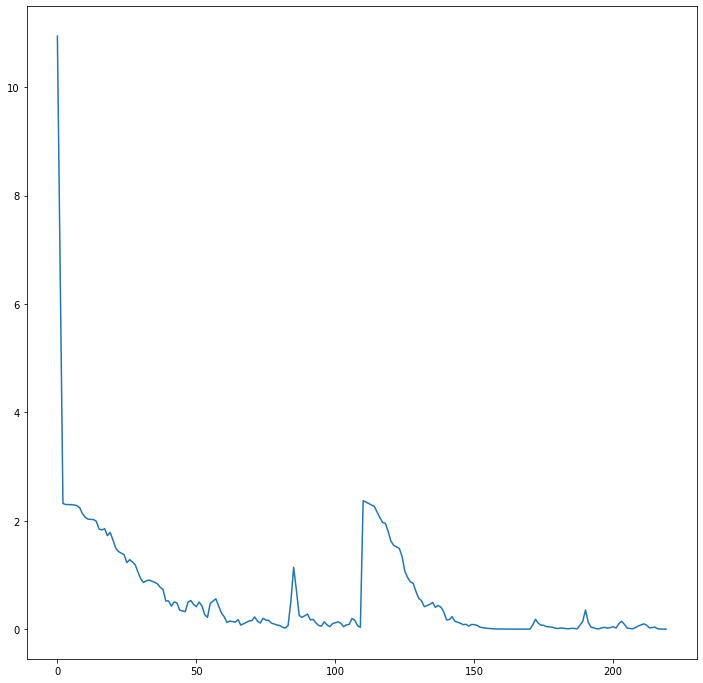

In [38]:
df.query("mode == 'train'")['loss'].plot()